In [1]:
# -*- coding: utf-8 -*-

## 시작하기 전에

현재 사용하는 데이터의 라벨을 먼저 만들어야 한다.


#### label_generator
label_generator.py는 데이터셋을 clone하여 여러 개의 데이터를 만들었을 때, 새로운 데이터들의 라벨이 없을 때 사용한다.

해당 프로그램은 파일의 경로와 해당 파일의 라벨을 clone된 파일의 이름을 통해 매칭하여 새로운 (경로 라벨)구조의 csv 파일을 만들어낸다.

인자로 (이미지 파일이 담긴 폴더의 경로), (\[파일명, 라벨\]순으로 정리되있는 라벨 데이터)를 받고

-o 옵션을 통해 아웃풋 파일의 경로를 정의 가능하다


```py
    python -m label_generator ./augmentation names.txt -o labels.csv
```

## Constants Definition

In [2]:
from util.constants import *

## Load Util Functions

In [3]:
from util.utils import *

## Load Global Datas

In [4]:
image_paths, encoded_labels, label_classes = load_original_datas(DATA_PATH)
total_images_cnt = len(image_paths)  # 총 이미지 개수

## SIFT keypoint extraction

In [5]:
@timer("SIFT")
def sift():
    import cv2
    import h5py
    import numpy as np


    # Variables
    processed_images_cnt = 0  # 현재 처리한 이미지 개수
    descriptor_idx = 0 # 현재 descriptor index

    # Array Initialization
    keypoint_idx_cnt = np.ndarray(shape=(total_images_cnt, 2), dtype="int32")
    all_keypoints = np.ndarray(shape=(TOTAL_DESCRIPTOR_CNT, 7), dtype="float32")
    all_descriptors = np.ndarray(shape=(TOTAL_DESCRIPTOR_CNT, DESCRIPTOR_LENGTH), dtype="float32")
    
    # SIFT
    for image_index in range(total_images_cnt):
        image_path = image_paths[image_index]
        image_label = encoded_labels[image_index]

        original_image = cv2.imread(image_path)
        grayscale_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

        sift = cv2.xfeatures2d.SIFT_create()
        keypoints, descriptors = sift.detectAndCompute(grayscale_image, None)

        # Descriptor가 없는 케이스에 대해 대처해야 함
        # keypoints가 None이 아니더라도, descriptors가 None이 되는 케이스가 있음
        # 따라서 descriptor == None을 체크
        if descriptors is not None:
            descriptors = descriptors.astype(np.float32, copy=False)
            descriptors = descriptors.reshape(-1, DESCRIPTOR_LENGTH)

            cur_keypoint_cnt = len(keypoints)
            descriptor_cnt = descriptors.shape[0]
            keypoint_idx_cnt[processed_images_cnt][0] = descriptor_idx
            keypoint_idx_cnt[processed_images_cnt][1] = descriptor_cnt
            if cur_keypoint_cnt != descriptor_cnt:
                print("!!!Keypoint cnt is diff from descriptor cnt!!!")
                print(cur_keypoint_cnt, " / ", descriptor_cnt)

            # 전체 keypoint, descriptor array에 값 채워넣기
            for keypoint, descriptor in zip(keypoints, descriptors):
                kp = keypoint
                kp_serialized = (kp.pt[0], kp.pt[1], kp.size, kp.angle, kp.response, kp.octave, kp.class_id)
                all_keypoints[descriptor_idx, :] = kp_serialized
                all_descriptors[descriptor_idx, :] = descriptor
                descriptor_idx += 1

        processed_images_cnt += 1
        if processed_images_cnt % 1000 == 0:
            print("[SIFT]{:>6d}/{:>6d}".format(processed_images_cnt, total_images_cnt))

    # 데이터 저장
    keypoint_info_file = h5py.File(SIFT_KEYPOINT_INFO_PATH, 'w')
    keypoint_info_file.create_dataset('keypoint_info', data=keypoint_idx_cnt)

    keypoint_file = h5py.File(SIFT_KEYPOINT_PATH, 'w')
    keypoint_file.create_dataset("keypoints", data=all_keypoints)
    
    descriptor_file = h5py.File(SIFT_DESCRIPTOR_PATH, 'w')
    descriptor_file.create_dataset("descriptors", data=all_descriptors)

In [6]:
sift()

[SIFT]-----Begin-----
[SIFT]  1000/  9191
[SIFT]  2000/  9191
[SIFT]  3000/  9191
[SIFT]  4000/  9191
[SIFT]  5000/  9191
[SIFT]  6000/  9191
[SIFT]  7000/  9191
[SIFT]  8000/  9191
[SIFT]  9000/  9191
[SIFT]-----End-----
[SIFT]Done in 32.03392028808594s


## Load SIFT processed data

In [7]:
from util.sift_data import SiftData

sift_data_paths = (SIFT_KEYPOINT_INFO_PATH, SIFT_KEYPOINT_PATH, SIFT_DESCRIPTOR_PATH)
sift_data = SiftData(sift_data_paths)

## kNN Classification

In [29]:
from sklearn.metrics import confusion_matrix

@timer("kNN")
def knn(data):
    import numpy as np
    from sklearn.neighbors import KNeighborsClassifier


    features = data.summed_descriptors
    labels = np.copy(encoded_labels)
    
    # Shuffle Data
    seed = 1234
    np.random.seed(seed)
    np.random.shuffle(features)
    np.random.seed(seed)
    np.random.shuffle(labels)

    train_ratio = 0.8
    train_set_cnt = int(features.shape[0] * train_ratio)
    train_datas, test_datas = np.split(features, [train_set_cnt])
    train_labels, test_labels = np.split(labels, [train_set_cnt])

    def check_kNN_test_result(k):
        types = ["TRAIN", "TEST"]
        datas = [train_datas, test_datas]
        labels = [train_labels, test_labels]
        
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(train_datas, train_labels)

        for i in range(len(types)):
            test_type = types[i]
            test_data = datas[i]
            test_label = labels[i]
            
            predicted_array = np.copy(test_label)

            correct = 0
            total = len(test_data)
            for idx in range(total):
                current_data = test_data[idx].reshape(1, -1)
                current_label = test_label[idx]

                predicted = model.predict(current_data)[0]
                predicted_array[idx] = predicted
                if predicted == current_label:
                    correct += 1
            accuracy = 100 * correct / total
            print("[k={}][{}]{:5}/{:5}({:.4f}%)".format(k, test_type, correct, total, accuracy))
            result_confusion_matrix = confusion_matrix(test_label, predicted_array)
            shorten_labels = [label.split("_")[0] for label in label_classes]
            print(shorten_labels)
            print(result_confusion_matrix, end="\n\n")

    for i in range(6):
        k = i * 2 + 1
        check_kNN_test_result(k)

In [9]:
knn(sift_data)

[kNN]-----Begin-----
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
[k=1][TRAIN] 7352/ 7352(100.0000%)
['decayed', 'dry', 'edge', 'encased', 'horn', 'leaf', 'sound']
[[ 234    0    0    0    0    0    0]
 [   0 1165    0    0    0    0    0]
 [   0    0 1104    0    0    0    0]
 [   0    0    0  486    0    0    0]
 [   0    0    0    0  575    0    0]
 [   0    0    0    0    0  784    0]
 [   0    0    0    0    0    0 3004]]

[k=1][TEST] 1649/ 1839(89.6683%)
['decayed', 'dry', 'edge', 'encased', 'horn', 'leaf', 'sound']
[[ 48   2   0   0   0   1   9]
 [  2 243   3  15   1   3  16]
 [  2   2 239   5   1   1  10]
 [  0   7   2 102   1   1  10]
 [  1   0   6   1 134  13   5]
 [  0   2   0   2   6 180  13]
 [  4  20   3   4   3  13 703]]

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
[k=3][

## k-means Clustering

In [10]:
import time
from sklearn.cluster import KMeans


kmeans_k = 8
random_seed = 426

print("[k-means]-----Begin-----")
# 타이머 적용 불가(함수로 래핑하여 사용시 KMeans의 인스턴스가 리턴시 GC되어 사라지는 문제가 있음)
# 때문에, 직접 시간 측정
time_start = time.time()
kmeans_model = KMeans(n_clusters=kmeans_k, random_state=random_seed).fit(sift_data.all_descriptors)
time_end = time.time()
time_diff = time_end - time_start

print("[k-means]Done in {}s".format(time_diff))

[k-means]-----Begin-----
[k-means]Done in 127.03055834770203s


## Visualization

#### 각 클래스별 descriptor 개수가 가장 많은 이미지를 k-means 클러스터별로 시각화

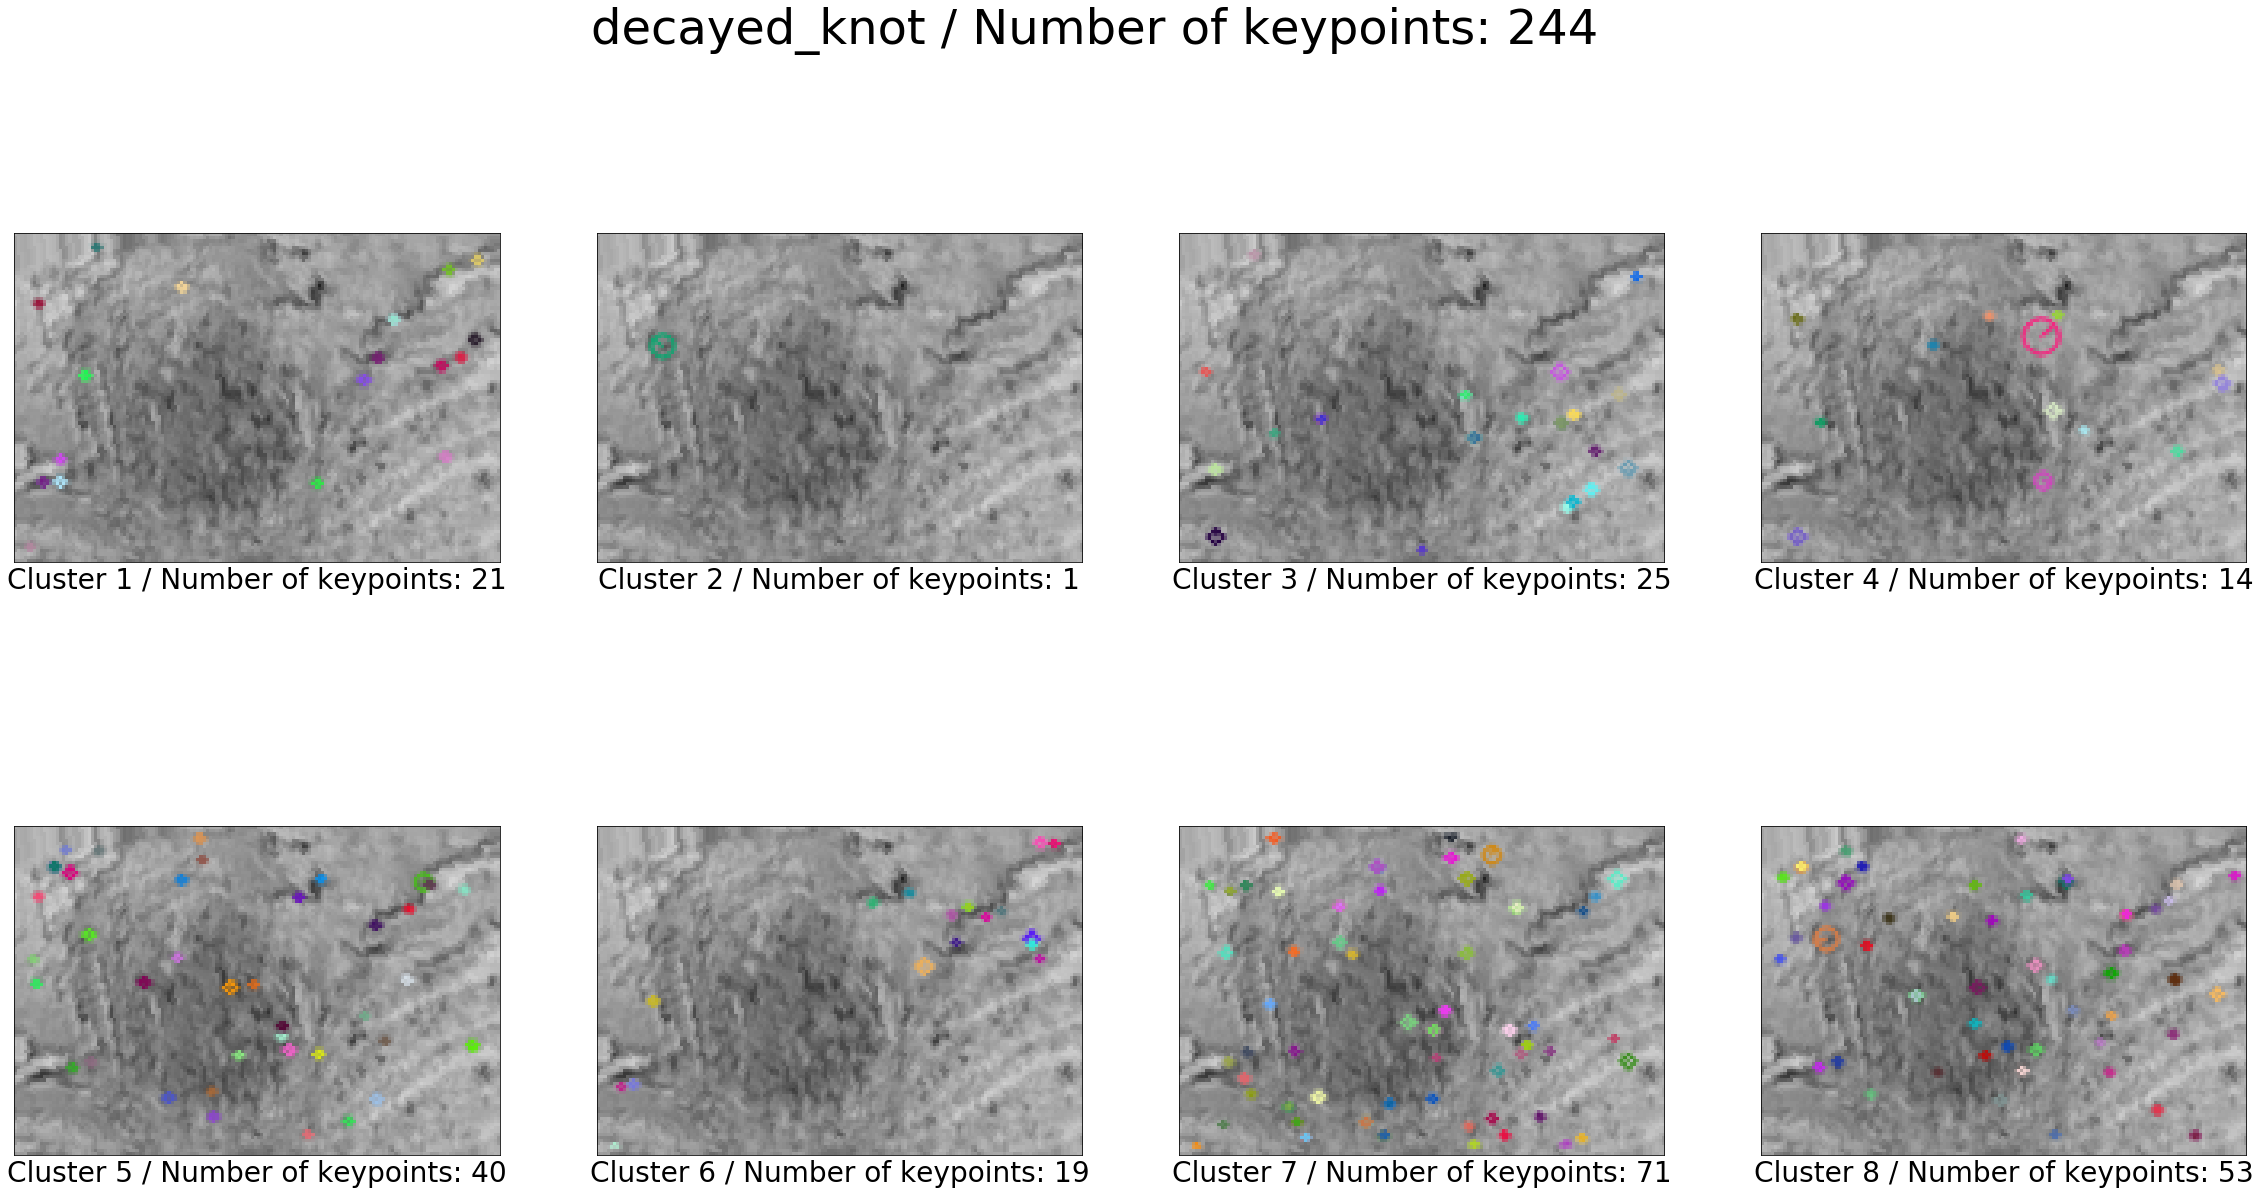

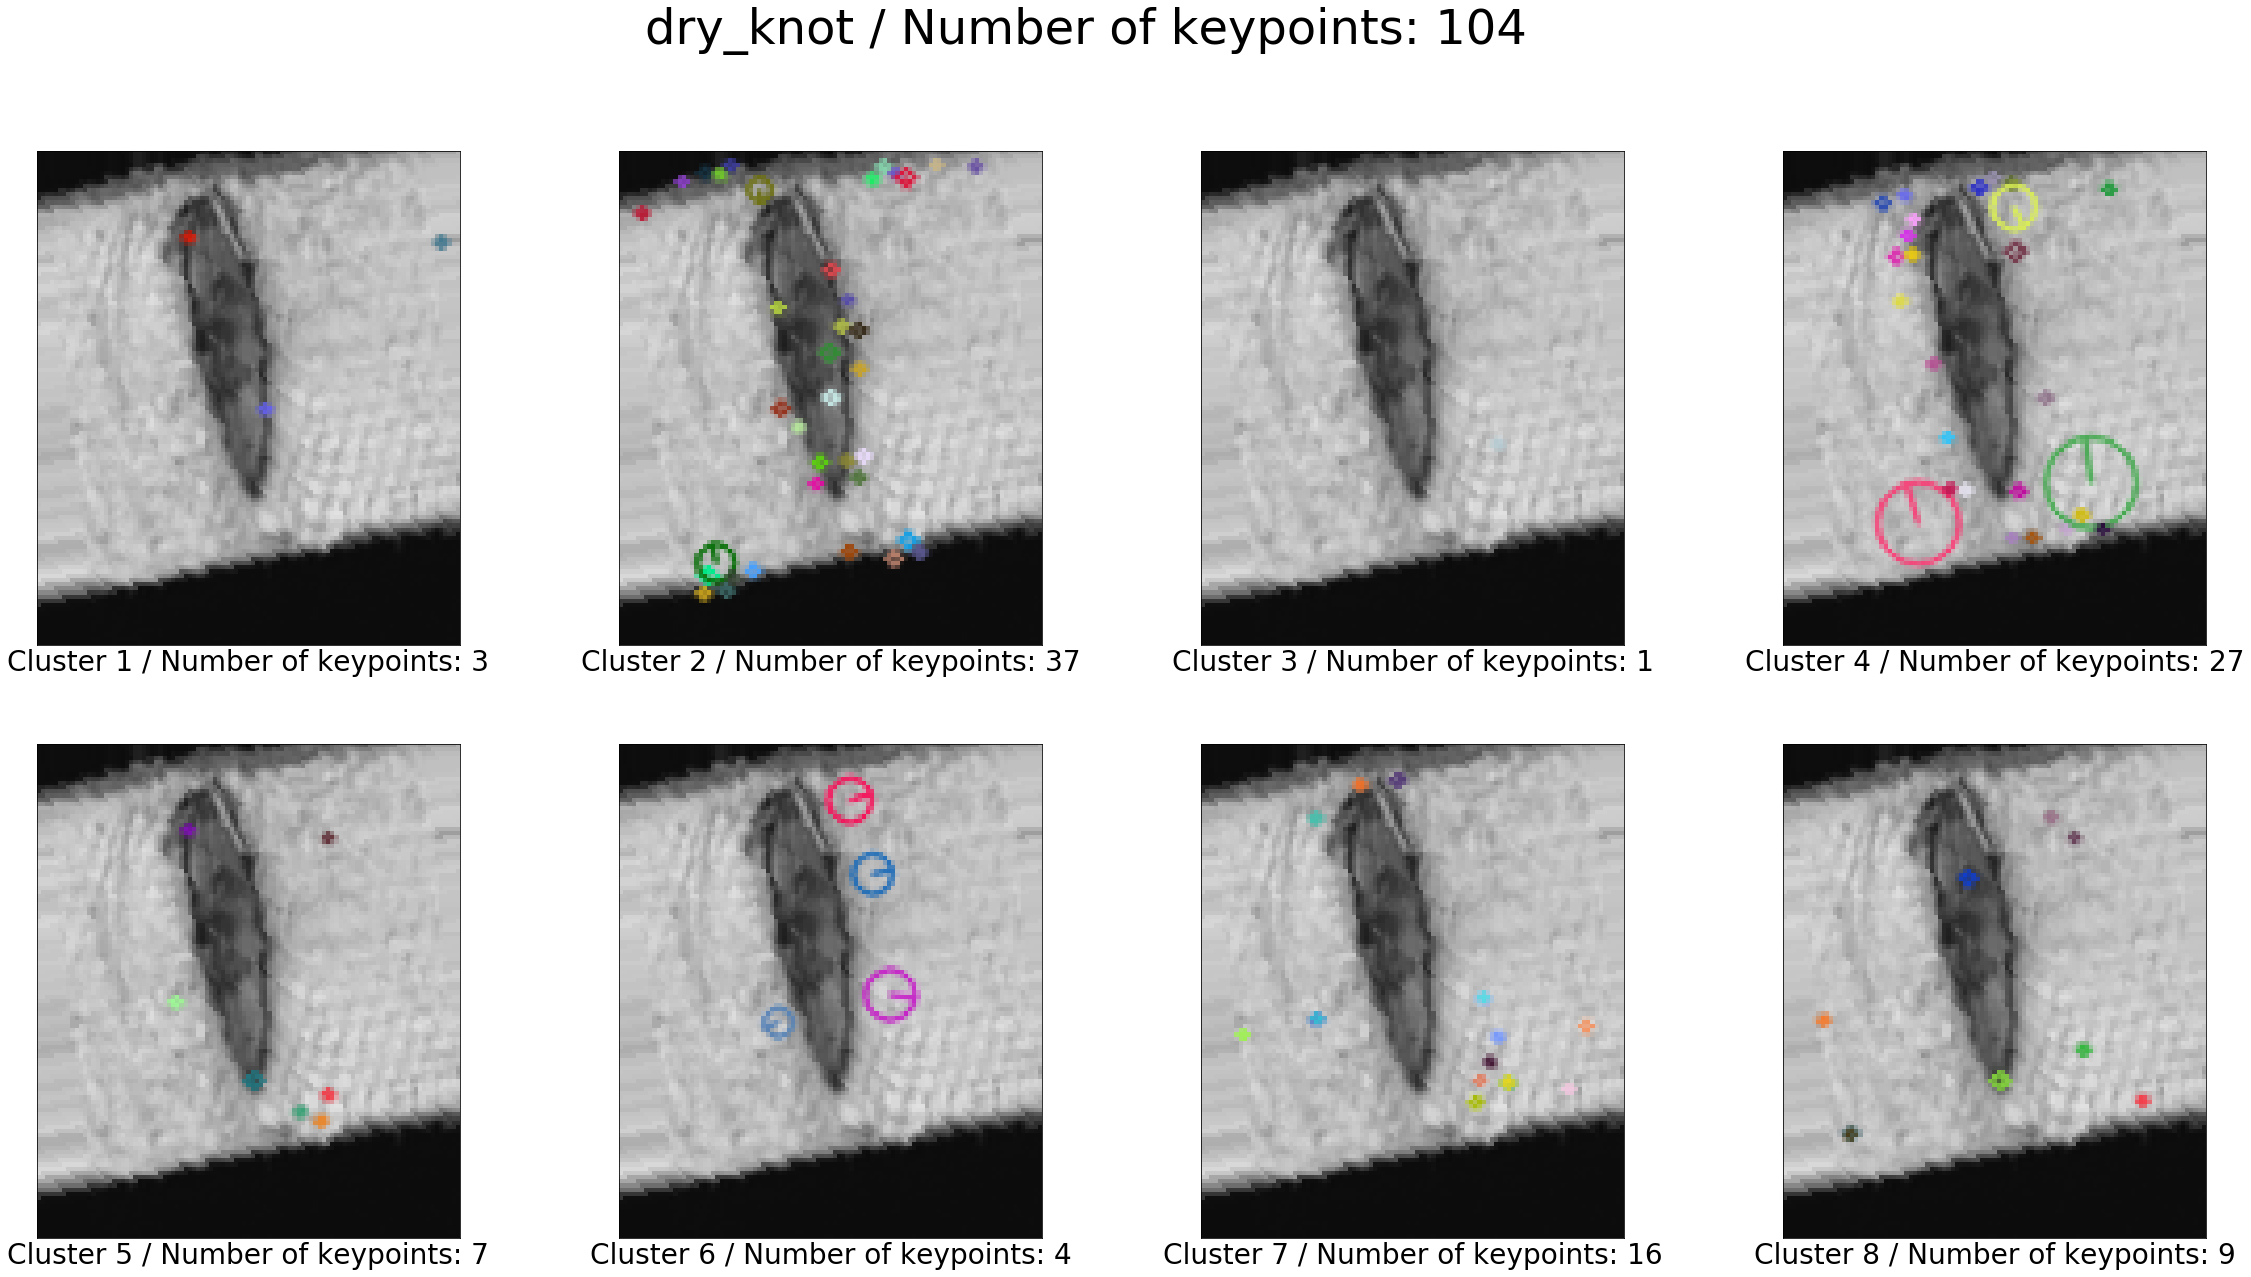

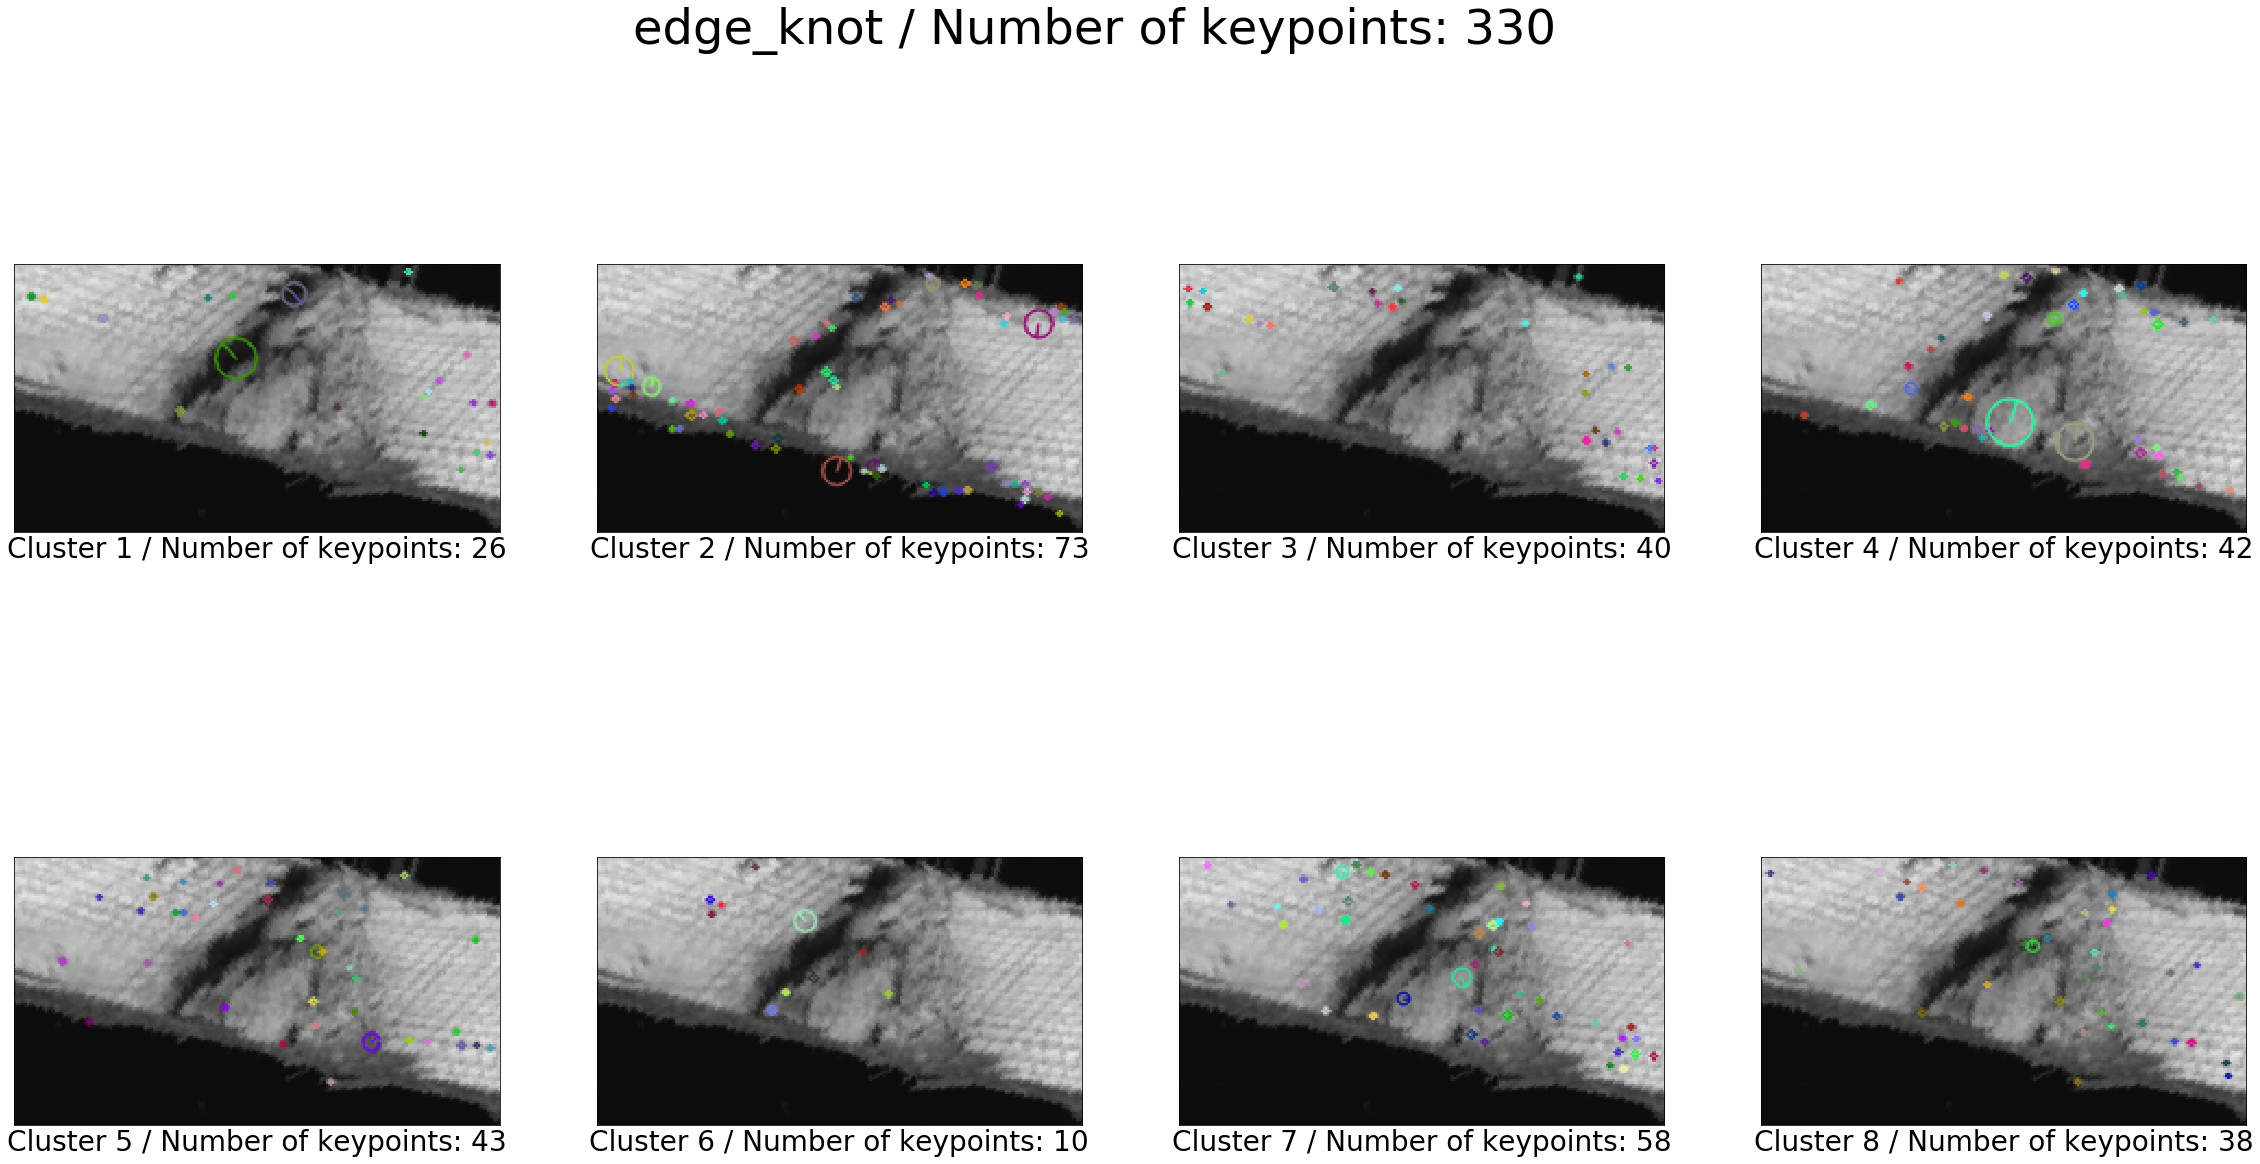

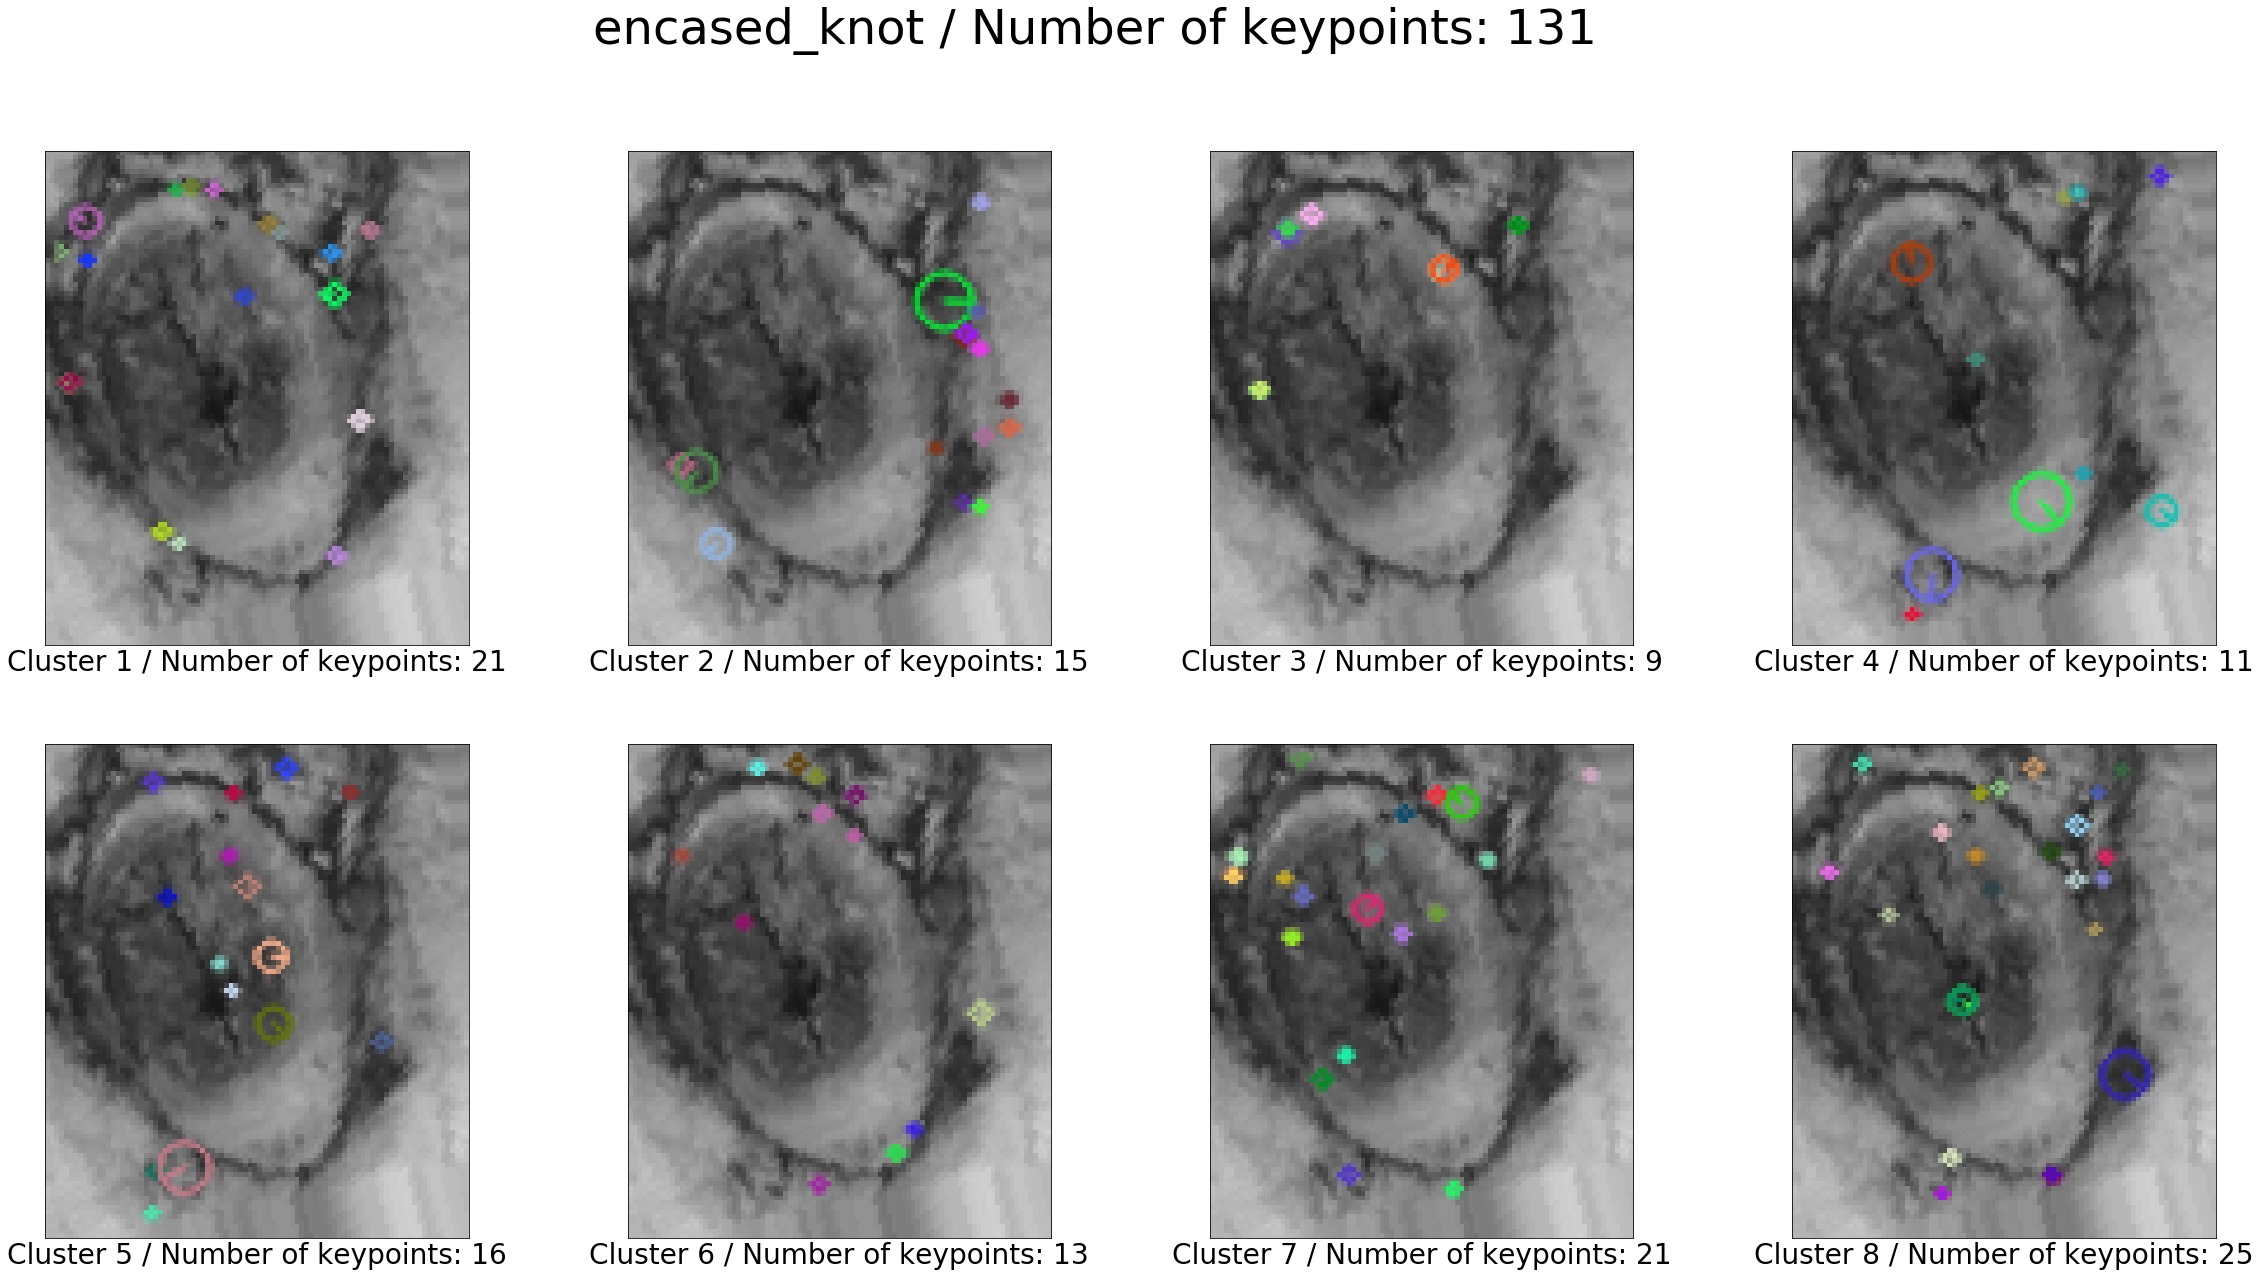

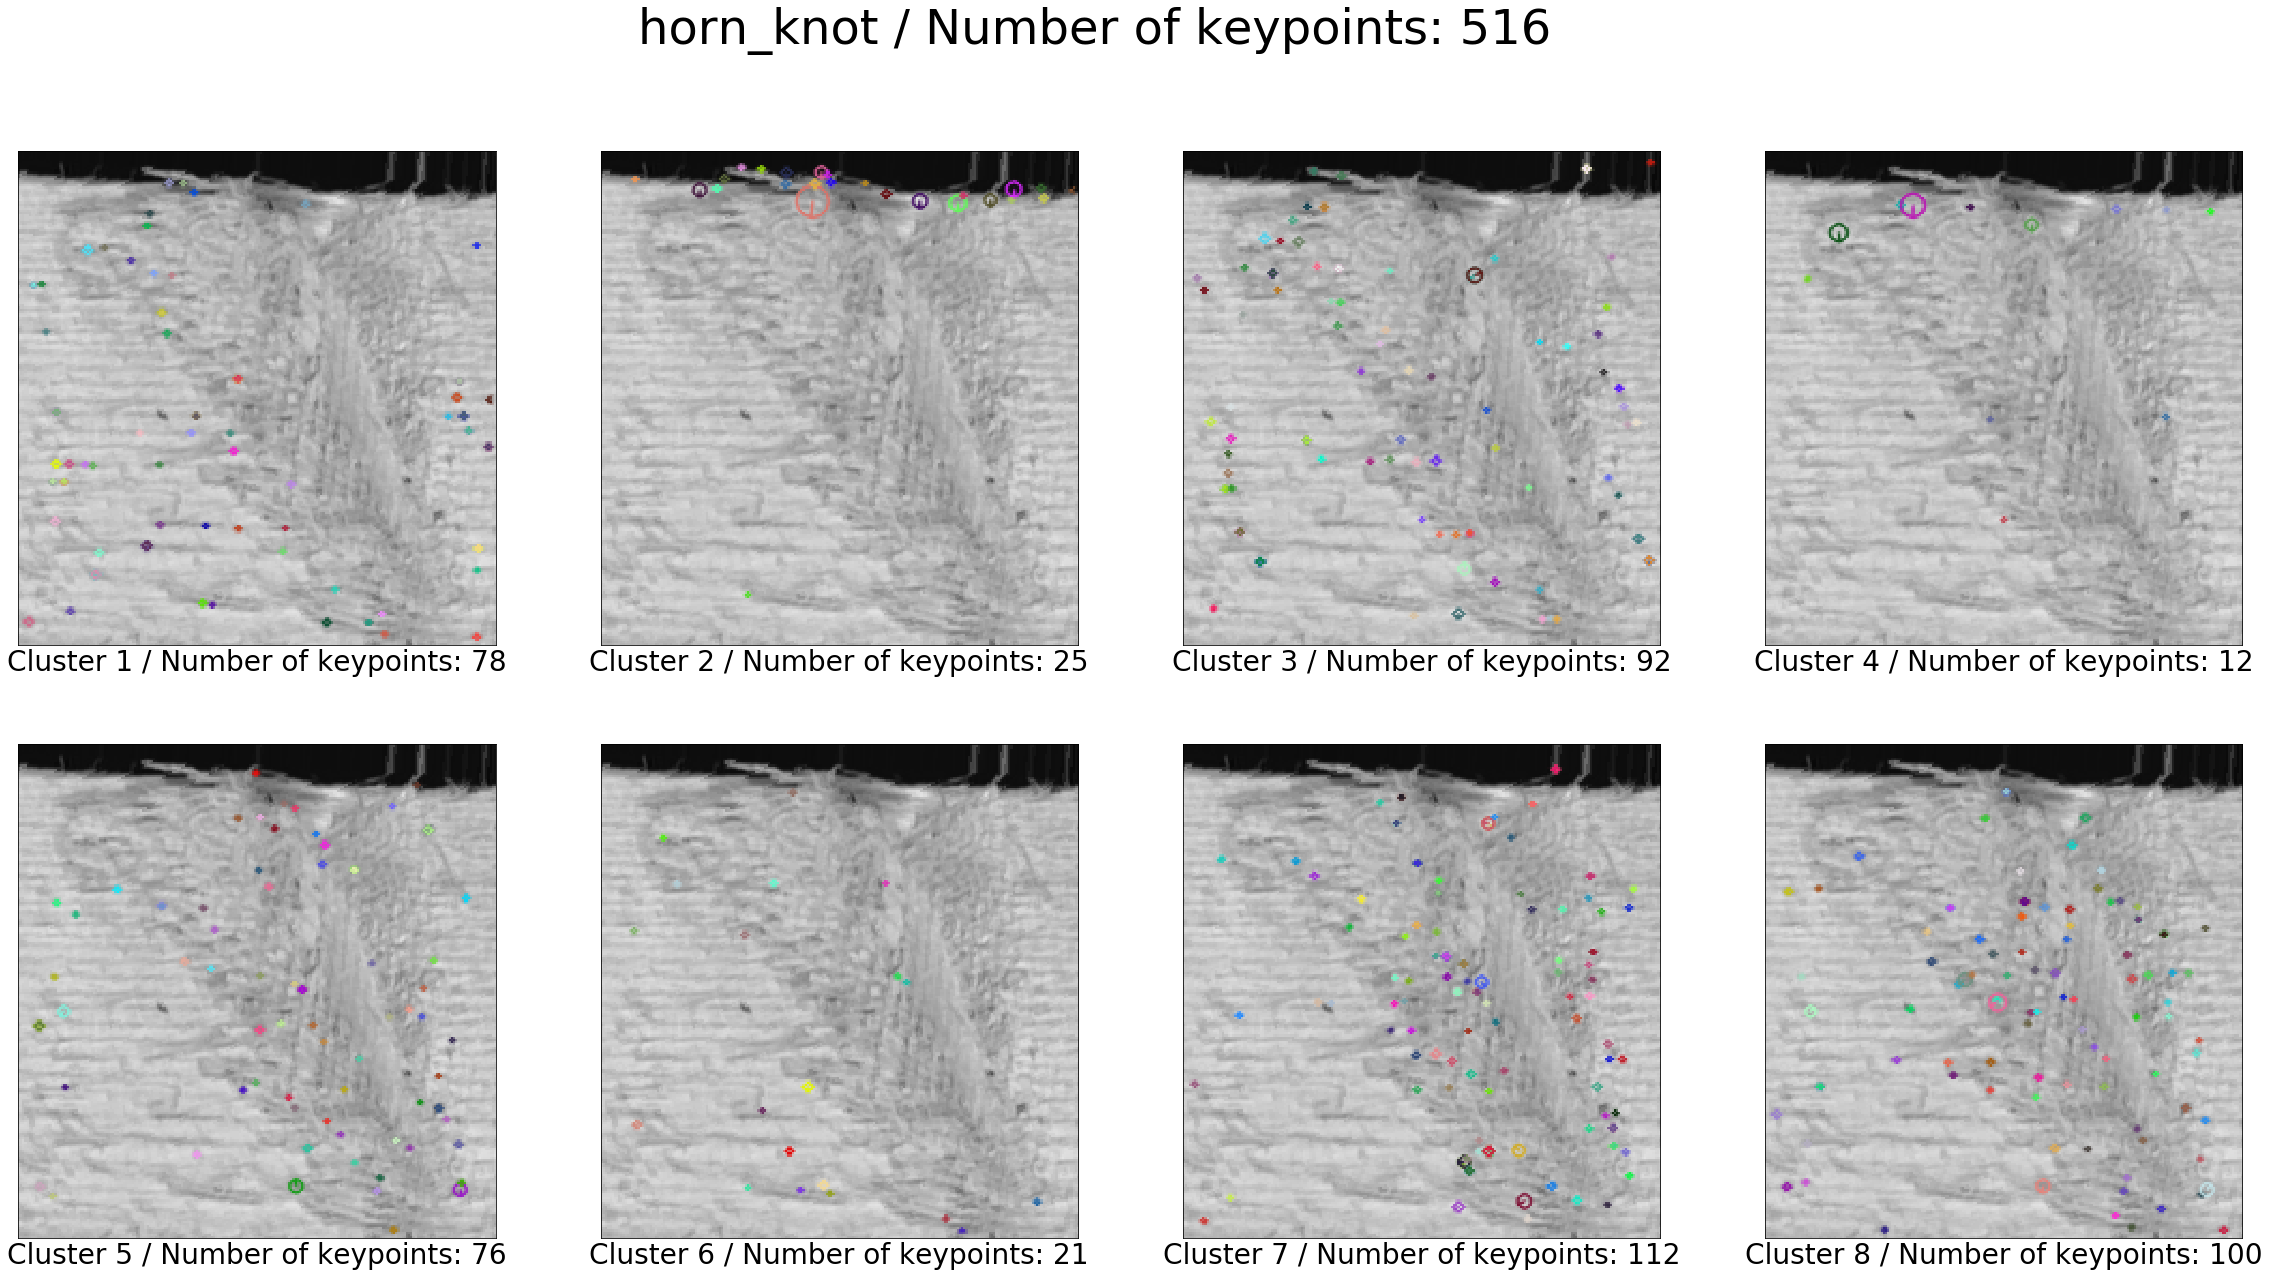

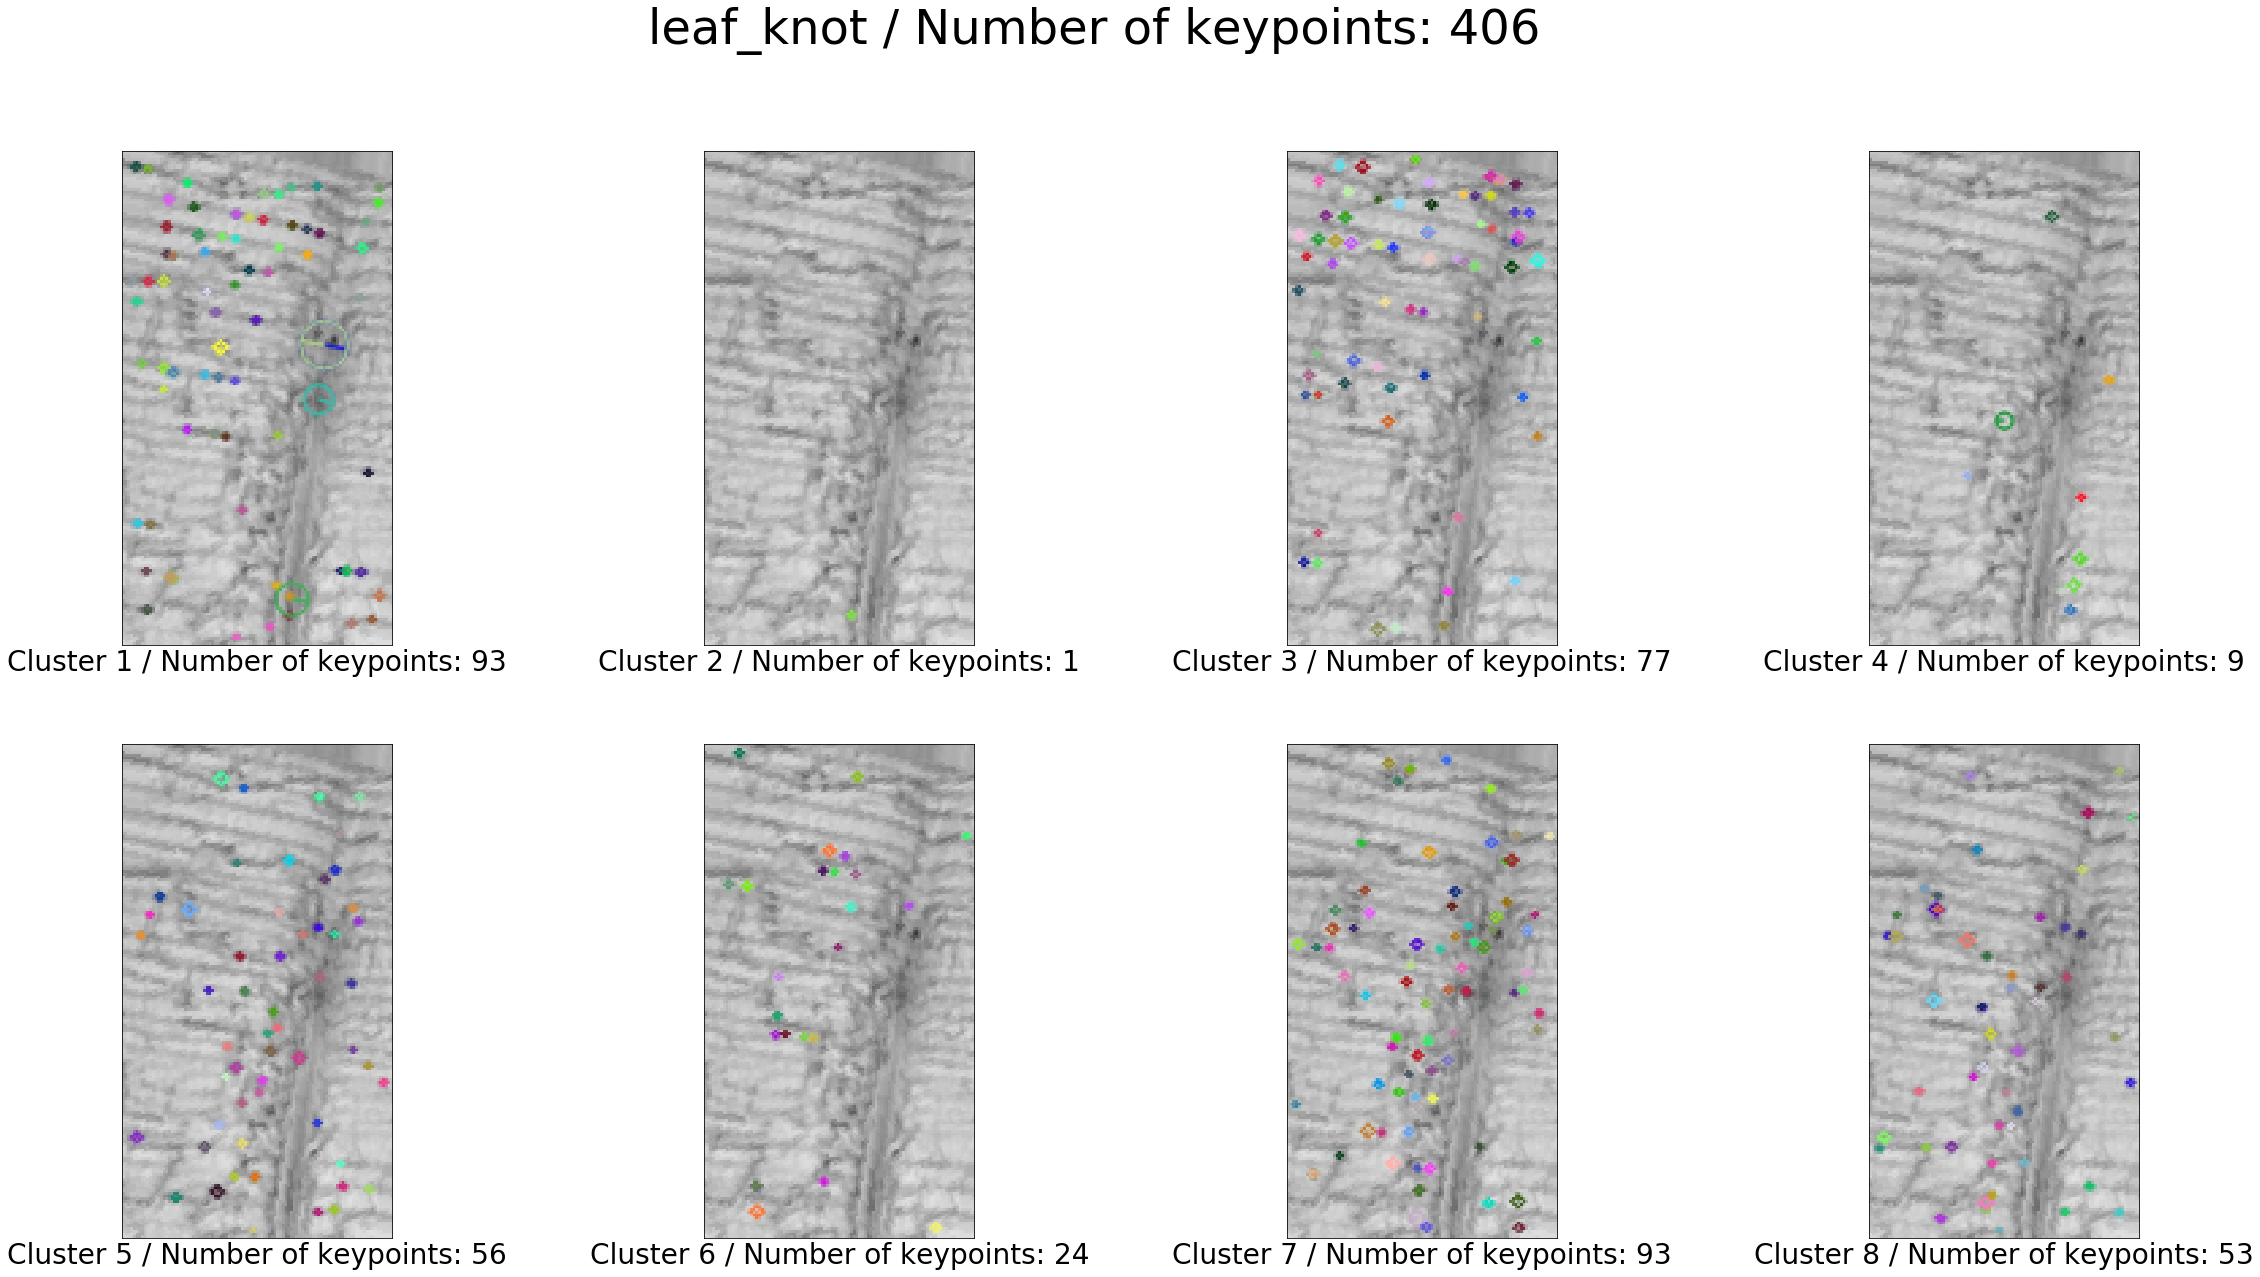

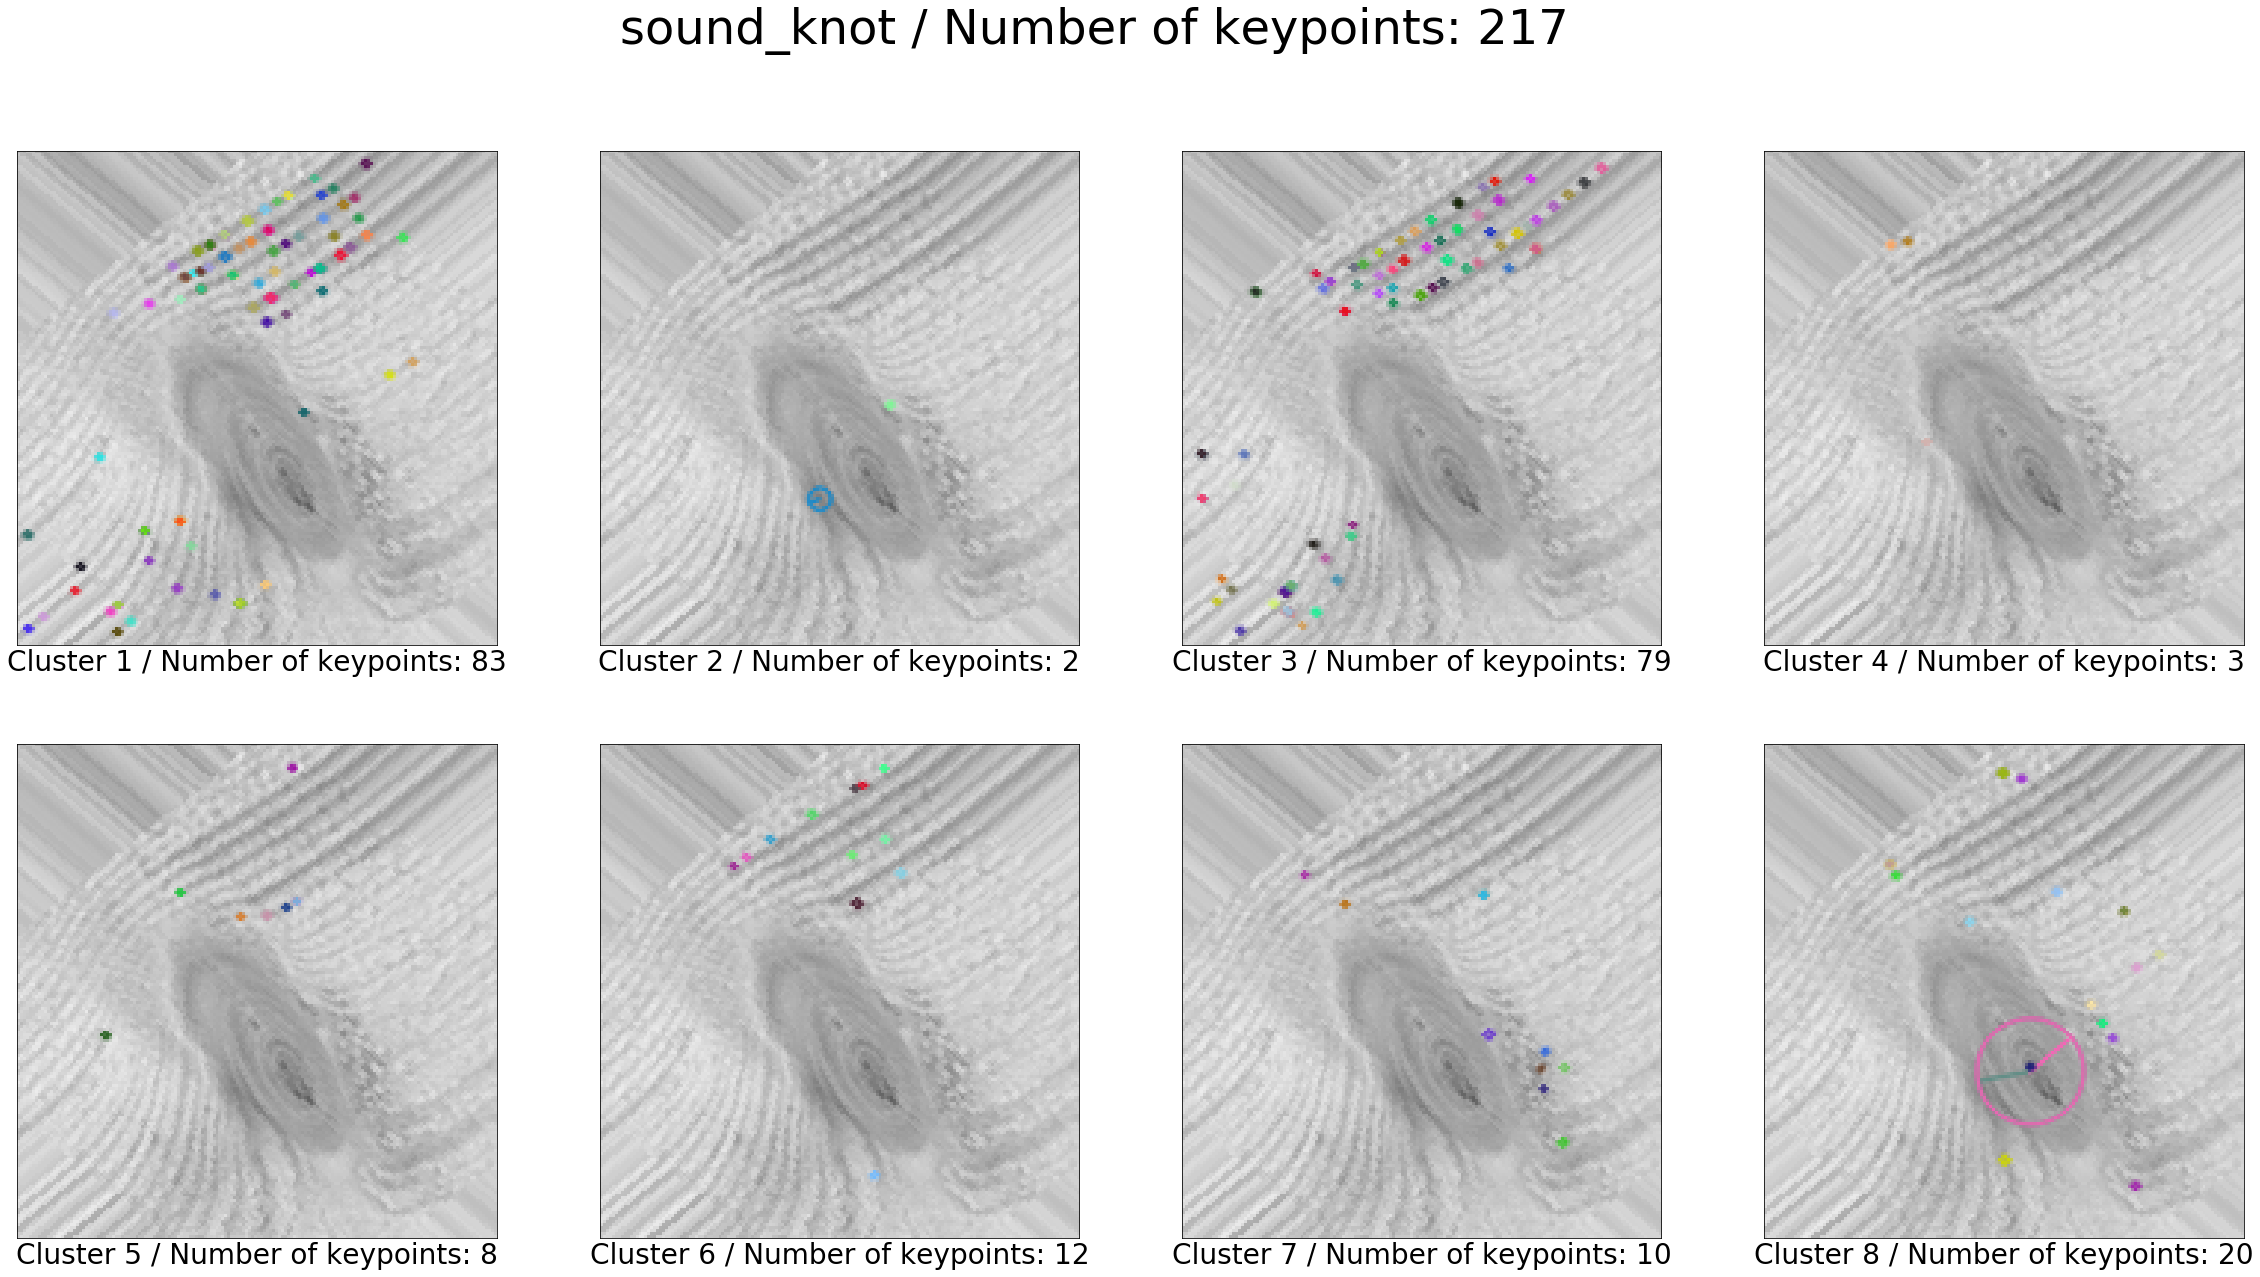

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# 각 클래스별로 가장 많은 descriptor를 갖는 이미지의 인덱스 계산
most_descriptor_cnt = np.zeros(shape=(CLASS_NUM), dtype="int32")
most_descriptor_idx = np.zeros(shape=(CLASS_NUM), dtype="int32")

for i in range(total_images_cnt):
    current_label = encoded_labels[i]
    keypoint_length = sift_data.keypoints_length_of(i)
    if keypoint_length > most_descriptor_cnt[current_label]:
        most_descriptor_cnt[current_label] = keypoint_length
        most_descriptor_idx[current_label] = i


# 앞서 구한 이미지들에 대해, 각 클러스터별로 keypoint위치 visualization
for image_idx in most_descriptor_idx:
    image_path = image_paths[image_idx]
    image_label_str = label_classes[encoded_labels[image_idx]]
    original_image = cv2.imread(image_path)
    grayscale_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    keypoints = sift_data.keypoints_of(image_idx)
    descriptors = sift_data.descriptors_of(image_idx)
    
    fig = plt.figure(figsize=(40, 20))
    for i in range(kmeans_k):
        if descriptors is not None:
            filtered_keypoints = []
            for j in range(descriptors.shape[0]):
                keypoint = keypoints[j]
                descriptor = descriptors[j]
                descriptor = descriptor.reshape(1, DESCRIPTOR_LENGTH)
                
                if kmeans_model.predict(descriptor) == i:
                    filtered_keypoints.append(keypoint)
            kmeans_img = cv2.drawKeypoints(grayscale_image, filtered_keypoints, outImage=np.array([]), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        else:
            kmeans_img = original_image
        fig.add_subplot(2, 4, i + 1)
        plt.imshow(kmeans_img)
        plt.xticks([]), plt.yticks([])
        plt.xlabel("Cluster {} / Number of keypoints: {}".format(i + 1, len(filtered_keypoints)), fontsize=28)
    plt.suptitle('{} / Number of keypoints: {}'.format(image_label_str, descriptors.shape[0]), fontsize=48)
    plt.show()

#### 클래스별 descriptor의 클러스터별 분포도 시각화

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

cluster_per_class = np.zeros(shape=(CLASS_NUM, kmeans_k), dtype="int32")

@timer("DESCRIPTOR K-MEANS PREDICTION")
def predict_descriptors():
    for i in range(total_images_cnt):
        current_label = encoded_labels[i]
        descriptors = sift_data.descriptors_of(i)
        if descriptors is not None:
            for j in range(descriptors.shape[0]):
                descriptor = descriptors[j]
                descriptor = descriptor.reshape(1, DESCRIPTOR_LENGTH)

                predicted_cluster = kmeans_model.predict(descriptor)[0]
                cluster_per_class[current_label][predicted_cluster] += 1
        if (i + 1) % 1000 == 0:
            print("[DESCRIPTOR K-MEANS PREDICTION]{:>6d}/{:>6d}".format(i + 1, total_images_cnt))


[DESCRIPTOR K-MEANS PREDICTION]-----Begin-----
[DESCRIPTOR K-MEANS PREDICTION]  1000/  9191
[DESCRIPTOR K-MEANS PREDICTION]  2000/  9191
[DESCRIPTOR K-MEANS PREDICTION]  3000/  9191
[DESCRIPTOR K-MEANS PREDICTION]  4000/  9191
[DESCRIPTOR K-MEANS PREDICTION]  5000/  9191
[DESCRIPTOR K-MEANS PREDICTION]  6000/  9191
[DESCRIPTOR K-MEANS PREDICTION]  7000/  9191
[DESCRIPTOR K-MEANS PREDICTION]  8000/  9191
[DESCRIPTOR K-MEANS PREDICTION]  9000/  9191
[DESCRIPTOR K-MEANS PREDICTION]-----End-----
[DESCRIPTOR K-MEANS PREDICTION]Done in 112.04831671714783s
[[ 1991  1545  1698  2409  3357  1147  4539  3739]
 [ 4847  3527  1899  5424  3417  3948  4202  5379]
 [ 7032 17540  4409 10076  7955  3850  8435  8542]
 [ 2930  3524   909  2428  2120  3053  2671  2553]
 [28422  9236 14145  5306 13867  8341 19347 17019]
 [24318  1043 16519  3198 12700  6727 19450 15237]
 [ 9475  8137  6654 13632 13186  5257 13286 17820]]


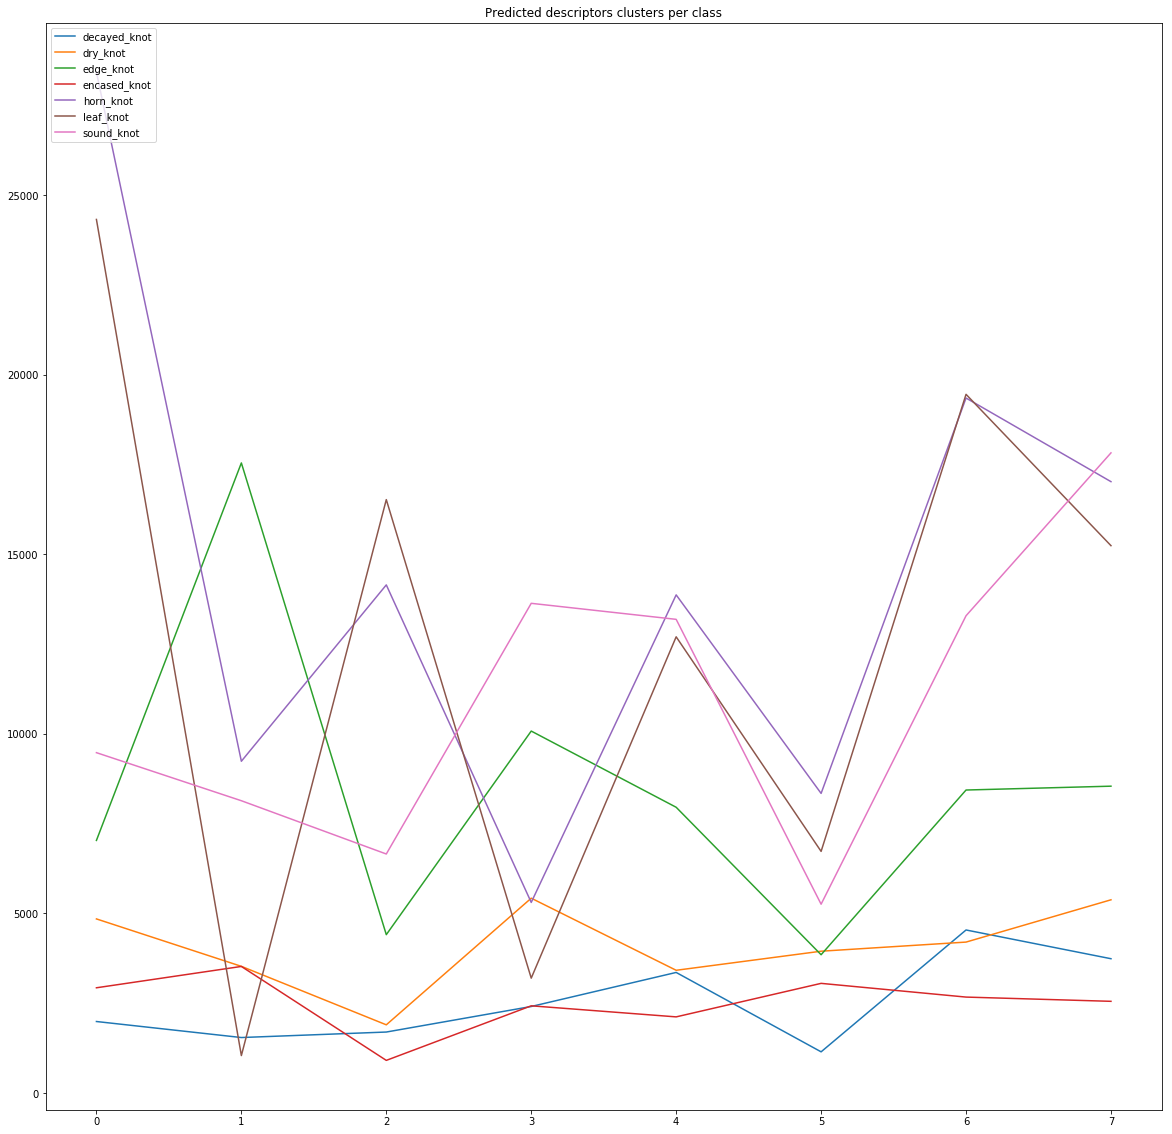

In [13]:
predict_descriptors()

print(cluster_per_class)
fig, ax = plt.subplots(figsize=(20, 20))
plt.title('Predicted descriptors clusters per class')
x = np.arange(kmeans_k)
for i in range(CLASS_NUM):
    plt.plot(x, cluster_per_class[i])
plt.xticks(x)
plt.legend(label_classes, loc='upper left')
plt.show()

#### 불필요한 타입의 Descriptor 제거 후 저장

- Cluster 1: 추재
- Cluster 2: 목재 외곽
- Cluster 3, 6: 춘재

In [25]:
import numpy as np
import h5py

# 배제할 클러스터 타입
cluster_indexes_to_exclude = [0, 1, 2, 5]

@timer("DESCRIPTOR EXCLUSION")
def exclude_descriptors_and_save_it():
    # 저장할 데이터
    excluded_keypoint_idx_cnt = np.ndarray(shape=(total_images_cnt, 2), dtype="int32")
    excluded_keypoints = np.ndarray(shape=(TOTAL_DESCRIPTOR_CNT, 7), dtype="float32")
    excluded_descriptors = np.ndarray(shape=(TOTAL_DESCRIPTOR_CNT, DESCRIPTOR_LENGTH), dtype="float32")
    
    # 통과시킨 descriptor의 개수
    descriptor_idx = 0

    for i in range(total_images_cnt):
        keypoints = sift_data.keypoints_of(i)
        descriptors = sift_data.descriptors_of(i)
        saved_keypoint_cnt = 0
        
        excluded_keypoint_idx_cnt[i][0] = descriptor_idx

        if descriptors is not None:            
            for j in range(descriptors.shape[0]):
                kp = keypoints[j]
                descriptor = descriptors[j]
                reshaped_descriptor = descriptor.reshape(1, DESCRIPTOR_LENGTH)

                predicted_cluster = kmeans_model.predict(reshaped_descriptor)[0]
                if predicted_cluster not in cluster_indexes_to_exclude:
                    kp_serialized = (kp.pt[0], kp.pt[1], kp.size, kp.angle, kp.response, kp.octave, kp.class_id)
                    excluded_keypoints[descriptor_idx, :] = kp_serialized
                    excluded_descriptors[descriptor_idx, :] = descriptor
                    descriptor_idx += 1
                    saved_keypoint_cnt += 1

        
        excluded_keypoint_idx_cnt[i][1] = saved_keypoint_cnt

        if (i + 1) % 1000 == 0:
            print("[DESCRIPTOR EXCLUSION]{:>6d}/{:>6d}".format(i + 1, total_images_cnt))

    # 데이터 재가공 후 저장
    excluded_keypoints = np.resize(excluded_keypoints, (descriptor_idx, 7))
    excluded_descriptors = np.resize(excluded_descriptors, (descriptor_idx, DESCRIPTOR_LENGTH))

    keypoint_info_file = h5py.File(EXCLUDED_KEYPOINT_INFO_PATH, 'w')
    keypoint_info_file.create_dataset('keypoint_info', data=excluded_keypoint_idx_cnt)

    keypoint_file = h5py.File(EXCLUDED_KEYPOINT_PATH, 'w')
    keypoint_file.create_dataset("keypoints", data=excluded_keypoints)
    
    descriptor_file = h5py.File(EXCLUDED_DESCRIPTOR_PATH, 'w')
    descriptor_file.create_dataset("descriptors", data=excluded_descriptors)
    
    print("[DESCRIPTOR EXCLUSION]{}/{} keypoints are saved".format(descriptor_idx, TOTAL_DESCRIPTOR_CNT))

In [26]:
exclude_descriptors_and_save_it()

[DESCRIPTOR EXCLUSION]-----Begin-----
[DESCRIPTOR EXCLUSION]  1000/  9191
[DESCRIPTOR EXCLUSION]  2000/  9191
[DESCRIPTOR EXCLUSION]  3000/  9191
[DESCRIPTOR EXCLUSION]  4000/  9191
[DESCRIPTOR EXCLUSION]  5000/  9191
[DESCRIPTOR EXCLUSION]  6000/  9191
[DESCRIPTOR EXCLUSION]  7000/  9191
[DESCRIPTOR EXCLUSION]  8000/  9191
[DESCRIPTOR EXCLUSION]  9000/  9191
[DESCRIPTOR EXCLUSION]241294/443431 keypoints are saved
[DESCRIPTOR EXCLUSION]-----End-----
[DESCRIPTOR EXCLUSION]Done in 290.5861978530884s


#### Cluster type에 따라 Exclusion을 마친 데이터에 대해 kNN수행

In [27]:
from util.sift_data import SiftData

excluded_sift_data_paths = (EXCLUDED_KEYPOINT_INFO_PATH, EXCLUDED_KEYPOINT_PATH, EXCLUDED_DESCRIPTOR_PATH)
excluded_sift_data = SiftData(excluded_sift_data_paths)

In [30]:
knn(excluded_sift_data)

[kNN]-----Begin-----
[k=1][TRAIN] 7331/ 7352(99.7144%)
['decayed', 'dry', 'edge', 'encased', 'horn', 'leaf', 'sound']
[[ 234    0    0    0    0    0    0]
 [   0 1165    0    0    0    0    0]
 [   0    4 1100    0    0    0    0]
 [   0    6    0  480    0    0    0]
 [   0    0    0    0  575    0    0]
 [   0    1    0    0    0  783    0]
 [   0   10    0    0    0    0 2994]]

[k=1][TEST] 1450/ 1839(78.8472%)
['decayed', 'dry', 'edge', 'encased', 'horn', 'leaf', 'sound']
[[ 40   3   1   1   1   2  12]
 [  1 212   1  17   6  10  36]
 [  1  10 208   3   4   5  29]
 [  0   9   7  76   0   4  27]
 [  0   1   9   3 117  20  10]
 [  1   5   5   0  17 153  22]
 [  5  41  20  10  10  20 644]]

[k=3][TRAIN] 6645/ 7352(90.3836%)
['decayed', 'dry', 'edge', 'encased', 'horn', 'leaf', 'sound']
[[ 209    6    1    0    0    4   14]
 [  16 1072    3    3    0    4   67]
 [   6   32  995    5    5    4   57]
 [   3   52   37  347    0    1   46]
 [   5    8   28    3  493   24   14]
 [   6   18 

#### 클래스별 descriptor의 배제된 클러스터별 분포도 시각화

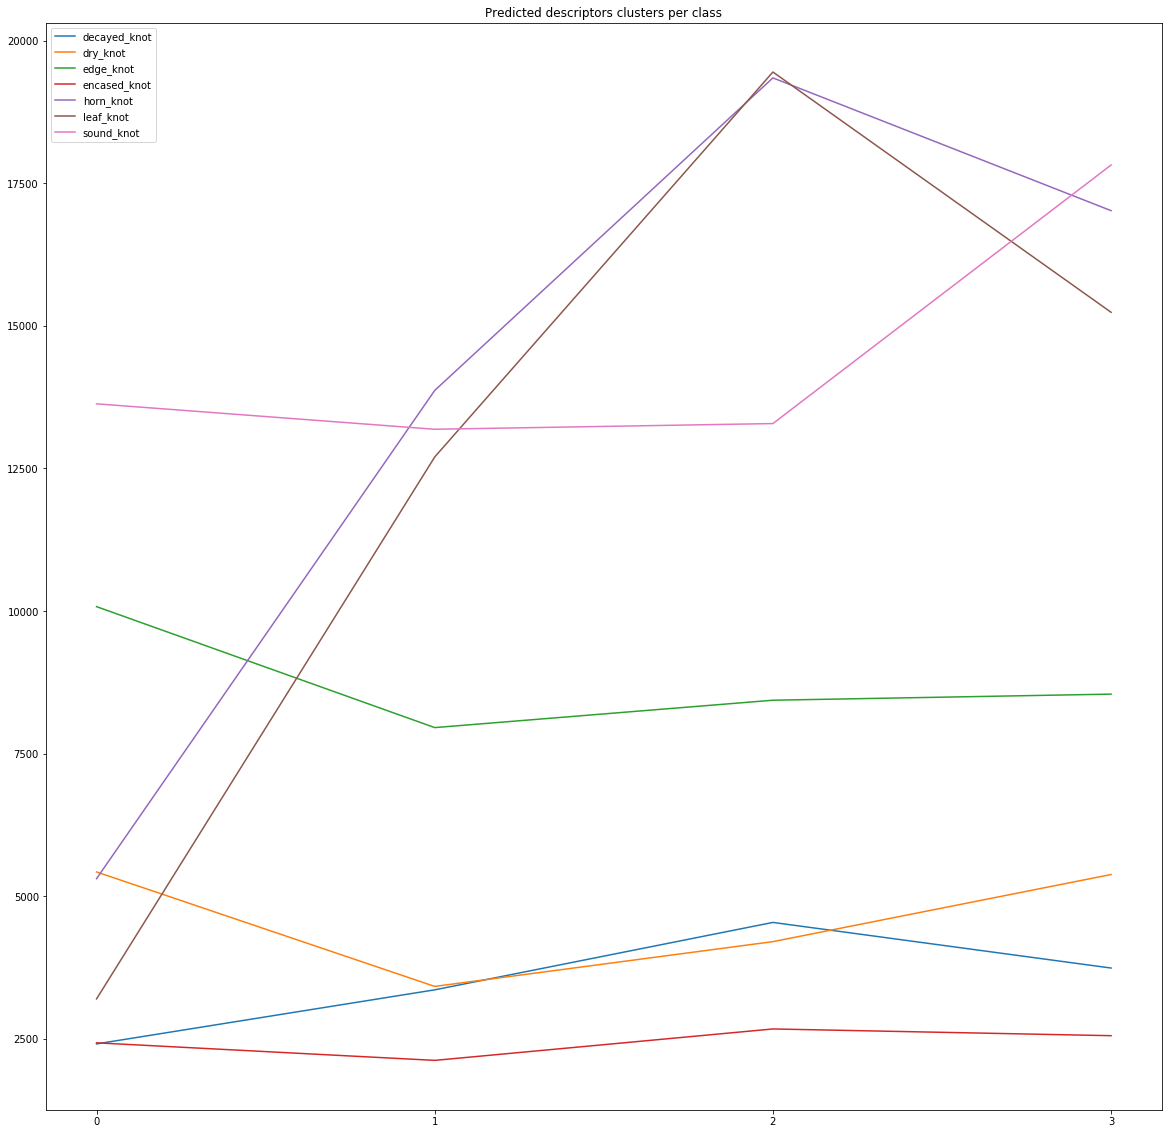

In [31]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.title('Predicted descriptors clusters per class')

excluded_cluster_num = kmeans_k - len(cluster_indexes_to_exclude)
x = np.arange(excluded_cluster_num)

for i in range(CLASS_NUM):
    current_idx = 0
    excluded_cluster_per_class = np.zeros(shape=(excluded_cluster_num), dtype="int32")
    for j in range(kmeans_k):
        if j not in cluster_indexes_to_exclude:
            excluded_cluster_per_class[current_idx] = cluster_per_class[i, j]
            current_idx += 1
    plt.plot(x, excluded_cluster_per_class)
plt.xticks(x)
plt.legend(label_classes, loc='upper left')
plt.show()